In [1]:
# Import libraries
import folktables
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import multiprocessing as mp
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

n_cores = mp.cpu_count()

# Constants
state_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
              'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']
cols = ['ST',
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
        'PINCP'
        ]
state_mapping = {
    '01': 'AL',
    '02': 'AK',
    '04': 'AZ',
    '05': 'AR',
    '06': 'CA',
    '08': 'CO',
    '09': 'CT',
    '10': 'DE',
    '11': 'DC',
    '12': 'FL',
    '13': 'GA',
    '15': 'HI',
    '16': 'ID',
    '17': 'IL',
    '18': 'IN',
    '19': 'IA',
    '20': 'KS',
    '21': 'KY',
    '22': 'LA',
    '23': 'ME',
    '24': 'MD',
    '25': 'MA',
    '26': 'MI',
    '27': 'MN',
    '28': 'MS',
    '29': 'MO',
    '30': 'MT',
    '31': 'NE',
    '32': 'NV',
    '33': 'NH',
    '34': 'NJ',
    '35': 'NM',
    '36': 'NY',
    '37': 'NC',
    '38': 'ND',
    '39': 'OH',
    '40': 'OK',
    '41': 'OR',
    '42': 'PA',
    '44': 'RI',
    '45': 'SC',
    '46': 'SD',
    '47': 'TN',
    '48': 'TX',
    '49': 'UT',
    '50': 'VT',
    '51': 'VA',
    '53': 'WA',
    '54': 'WV',
    '55': 'WI',
    '56': 'WY',
    '72': 'PR'
}

# COW_map = {
#     5.0: 99,
#     7.0: 99,
#     8.0: 99,
# }
# 
# SCHL_map = {
#     23.0: 99,
#     17.0: 99,
#     24.0: 99,
#     14.0: 99,
#     15.0: 99,
#     13.0: 99,
#     1.0: 99,
#     12.0: 99,
#     11.0: 99,
#     9.0: 99,
#     10.0: 99,
#     8.0: 99,
#     6.0: 99,
#     7.0: 99,
#     5.0: 99,
#     2.0: 99,
#     4.0: 99,
#     3.0: 99
# }
# 
# MAR_map = {
#     2.0: 99,
#     4.0: 99,
# }
# 
# RAC1P_map = {
#     9: 99,
#     3: 99,
#     5: 99,
#     7: 99,
#     4: 99
# }


The following downloads the data from folktables. This is also stored as a pickle file 'acs_data_df.p'

In [2]:
### Download data from folktables
#ACSIncome = folktables.BasicProblem(
#    features=[
#        'AGEP',
#        'COW',
#        'SCHL',
#        'MAR',
#        'OCCP',
#        'POBP',
#        'RELP',
#        'WKHP',
#        'SEX',
#        'RAC1P',
#    ],
#    target='PINCP',
#    preprocess=folktables.adult_filter,
#    postprocess=lambda x: np.nan_to_num(x, -1),
#)
#
#data_source = folktables.ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
#acs_data = data_source.get_data(states=state_list, download=False)
#acs_data_df = acs_data[acs_data.columns.intersection(cols)]
#acs_data_df.to_pickle('ACSIncome_transf.p')
#
# Read in saved data
# X_raw = pd.read_pickle("acs_data_df.p") 

This next chunk preprocesses data. It is saved as the pickle file 'ACSIncome_transf.p'


In [3]:
# ## Exclude DC
# all_states = X_raw['ST'].unique()
# all_states = all_states[(all_states != 11)] 
# 
# ## Check how many samples per state
# states_nsize = pd.DataFrame({
#     "n": [sum(X_raw['ST'] == s) for s in all_states],
#     "state": all_states,
# }).sort_values(by='n', ascending=False)
#
# ## Focus on the 10 largest states in terms of samples
# states = states_nsize.iloc[0:11, 1].reset_index(drop=True)
# states_trunc = states_nsize.iloc[1:11, 1].reset_index(drop=True)
# 
# 
# ## Remove NAs and the state cols
# X_raw_subset = X_raw[X_raw['ST'].isin(list(states))].dropna(how='any').reset_index(drop=True)
# X_raw_subset = X_raw.dropna(how='any').reset_index(drop=True)
# 
# ## Clean data to exclude negative incomes and do log transform
# X_raw_subset = X_raw_subset[X_raw_subset['PINCP'] >= 0]
# X_raw_subset["PINCP"] = np.log(X_raw_subset["PINCP"])
# 
# ## Remap some values  
# X_raw_subset['WKHP'] = X_raw_subset['WKHP'].map(lambda x: x if x != 40.0 else 99)
# X_raw_subset['COW'] = X_raw_subset['COW'].map(lambda x: x if x not in COW_map.keys() else COW_map[x])
# X_raw_subset['MAR'] = X_raw_subset['MAR'].map(lambda x: x if x not in MAR_map.keys() else MAR_map[x])
# X_raw_subset['SCHL'] = X_raw_subset['SCHL'].map(lambda x: x if x not in SCHL_map.keys() else SCHL_map[x])
# X_raw_subset['RAC1P'] = X_raw_subset['RAC1P'].map(lambda x: x if x not in RAC1P_map.keys() else RAC1P_map[x])

# ## One hot encode categorical vars
# X_categorical = X_raw_subset.drop(["ST", "PINCP", 'AGEP', 'WKHP', 'RELP', 'POBP', 'OCCP'], axis=1)
# X_transf = pd.concat([pd.get_dummies(X_categorical, columns = list(X_categorical.columns), dtype=float), X_raw_subset[["ST", "PINCP", 'AGEP', 'WKHP']]], axis=1).reset_index(drop=True)
# X = pd.DataFrame(StandardScaler(with_mean=False).fit_transform(X_transf.drop(["ST"], axis=1)), columns=X_transf.drop(["ST"], axis=1).columns).reset_index(drop=True)
# X['ST'] = X_transf['ST']
# 
# del X_raw, X_raw_subset, X_categorical, X_transf
# # X.to_pickle('ACSIncome_transf.p')

## Read in cleaned data
X = pd.read_pickle("ACSIncome_transf.p") 
states = X['ST'].unique()
states_trunc = states[(states != 6)] # Use CA (code 6) as target 
# print(states)

In [4]:
def get_weights(X, n_k, state, y_reg, Xbar_kpt):
    """
    Get optimal weights and estimated DUC for datasets. The notation below follows notation from the manuscript
    
    :param X: Covariate data to calculate Ehat_source(X) 
    :param n_k: number of source samples
    :param state: state to use for source
    :param y_reg: E_target(X)-Ehat_target(X)
    :param Xbar_kpt: Ehat_target(X)
    :return: dict of {source samples, weights, DUC}
    """
    
    # Sample from source
    samples_s = X[X['ST'] == state].sample(n=n_k)
    Xbar_kp = np.mean(samples_s.drop(["ST", "PINCP"],axis=1), axis=0)

    # Calc weights
    x_s = Xbar_kp - Xbar_kpt
    weights = LinearRegression(fit_intercept=False).fit(np.array(x_s).reshape(-1, 1), np.array(y_reg).reshape(-1, 1)).coef_[0]
    weights_trunc = pd.Series(weights).apply(lambda x: 1 if x > 1 else x).apply(lambda x: 0 if x < 0 else x)[0] # Make sure weights are between 0,1

    # Estimate DUC
    corr_sq = pearsonr(y_reg,x_s)[0]**2
    var_x = np.var(x_s)
    
    # Correctly calculate it if weights were truncated
    if weights_trunc == 0:
        duc = 0
    elif weights_trunc ==1:
        duc = var_x/np.var(y_reg)
    else:
        duc = corr_sq 
    
    results = {
        'samples_s': samples_s,
        'weights': weights_trunc,
        'duc': duc,
    }
    
    return results

def run_experiment(X, n_test, n_k, n_t, states_trunc,target_id=6):
    """
    Runs experiment per Fig 5
    
    :param X: ACS data
    :param n_test: samples for testing
    :param n_k: samples for source
    :param n_t: samples for target
    :param states_trunc: source states to use
    :param target_id: ACS state code for target
    :return: 
    """
    
    # Calculate E_target[phi]
    test_indices = random.sample(X.index[X['ST'] == target_id].to_list(), n_test)
    samples_test = X[X.index.isin(test_indices)]
    Xbar_test = np.mean(samples_test.drop(["ST", "PINCP"],axis=1), axis=0)
    X_new = X.drop(test_indices, axis=0)

    # Calculate Ehat_target[phi]
    samples_t = X_new[X_new['ST'] == target_id].sample(n=n_t)
    Xbar_kpt = np.mean(samples_t.drop(["ST", "PINCP"],axis=1), axis=0)
    y_reg = Xbar_test - Xbar_kpt
    
    # Run all sources in parallel
    res = Parallel(n_jobs=n_cores, verbose=0)(delayed(get_weights)(X_new, n_k,s, y_reg, Xbar_kpt) for s in states_trunc)

    # Unpack
    samples_list = [res[s].get('samples_s') for s in range(len(states_trunc))]
    weights_list = [res[s].get('weights') for s in range(len(states_trunc))]
    duc_list = [res[s].get('duc') for s in range(len(states_trunc))]
    
    ##### comparisons
    # Using target only
    fit_target = RandomForestRegressor().fit(samples_t.drop(['ST', "PINCP"], axis=1),samples_t["PINCP"])
    y_hat_t = fit_target.predict(samples_test.drop(["ST", "PINCP"], axis=1))
    target_mse = np.mean((samples_test["PINCP"]-y_hat_t)**2)
    
    # Pooling
    samples_st_list = [pd.concat([samples_s, samples_t]) for samples_s in samples_list]
    y_hat_pool_list = [RandomForestRegressor().fit(samples_st.drop(['ST', "PINCP"], axis=1),samples_st["PINCP"]).predict(samples_test.drop(["ST", "PINCP"], axis=1)) for samples_st in samples_st_list]
    pool_mse_list = [np.mean((samples_test["PINCP"]-y_hat_pool)**2) for y_hat_pool in y_hat_pool_list]
    
    # Optimal
    y_hat_s_list = [RandomForestRegressor().fit(samples_s.drop(['ST', "PINCP"], axis=1),samples_s["PINCP"]).predict(samples_test.drop(["ST", "PINCP"], axis=1)) for samples_s in samples_list]
    y_hat_weighted_list = [w*y_hat_s+(1-w)*y_hat_t for w,y_hat_s in zip(weights_list, y_hat_s_list)]
    weighted_mse_list = [np.mean((samples_test["PINCP"]-y_hat_weighted)**2) for y_hat_weighted in y_hat_weighted_list]

    
    results = {
        'target_mse': target_mse,
        'pool_mse_list': pool_mse_list,
        'weighted_mse_list': weighted_mse_list,
        'weights_list': weights_list,
        'duc_list': duc_list,
    }
    return results





The next chunk runs the experiment. Caution: takes a while to run

In [5]:
# Setting
n_t = 30
n_k = 1000
n_test = 10000
trials = 100

# # Set a global random seed
# global_seed = 1
# random.seed(global_seed)
# np.random.seed(global_seed)
# 
# # Generate a unique seed for each trial
# trial_seeds = [i for i in range(trials)]
# 
# # Function to run an experiment with a seed
# def run_experiment_with_seed(seed, X, n_test, n_k, n_t, states_trunc):
#     # Set the seed for the worker
#     random.seed(seed)
#     np.random.seed(seed)
#     
#     # Run the experiment
#     return run_experiment(X, n_test, n_k, n_t, states_trunc)
# 
# # Run experiments in parallel
# results = Parallel(n_jobs=n_cores, verbose=0)(
#     delayed(run_experiment_with_seed)(seed, X, n_test, n_k, n_t, states_trunc) for seed in trial_seeds
# )
#
# ## Unpack results into df
# results_df = pd.DataFrame({"state": states_trunc, 
#                            'weights': [np.mean([results[t].get('weights_list')[s] for t in range(trials)]) for s in range(len(states_trunc))],
#                            "pool_mse_list": [np.mean([results[t].get('pool_mse_list')[s] for t in range(trials)]) for s in range(len(states_trunc))],
#                            "weighted_mse_list": [np.mean([results[t].get('weighted_mse_list')[s] for t in range(trials)]) for s in range(len(states_trunc))],
#                            "duc": [np.mean([results[t].get('duc_list')[s] for t in range(trials)]) for s in range(len(states_trunc))], 
#                            }).sort_values(by='duc', ascending=False).reset_index(drop=True)
# # Convert the state column to string if it's not already
# results_df['state'] = results_df['state'].astype(str)
# # Map the state numbers to abbreviations
# results_df['state_abbreviation'] = results_df['state'].replace(state_mapping)
# 
# results_df.to_csv("results_fig5.csv", index=False)

In [6]:
results_df = pd.read_csv('results_fig5.csv')
results_df

,state,weights,pool_mse_list,weighted_mse_list,duc,state_abbreviation
0,36,0.689621,0.576772,0.556058,0.686934,NY
1,34,0.690615,0.583274,0.558005,0.679832,NJ
2,48,0.632787,0.603708,0.568140,0.625510,TX
3,17,0.572730,0.578556,0.564142,0.578850,IL
4,37,0.521792,0.609246,0.580433,0.525377,NC
5,12,0.520482,0.599848,0.583808,0.523592,FL
6,13,0.481645,0.600682,0.582416,0.481915,GA
7,26,0.460675,0.605310,0.591997,0.473993,MI
8,39,0.444502,0.593749,0.592551,0.456714,OH
9,42,0.434130,0.603043,0.595489,0.448329,PA


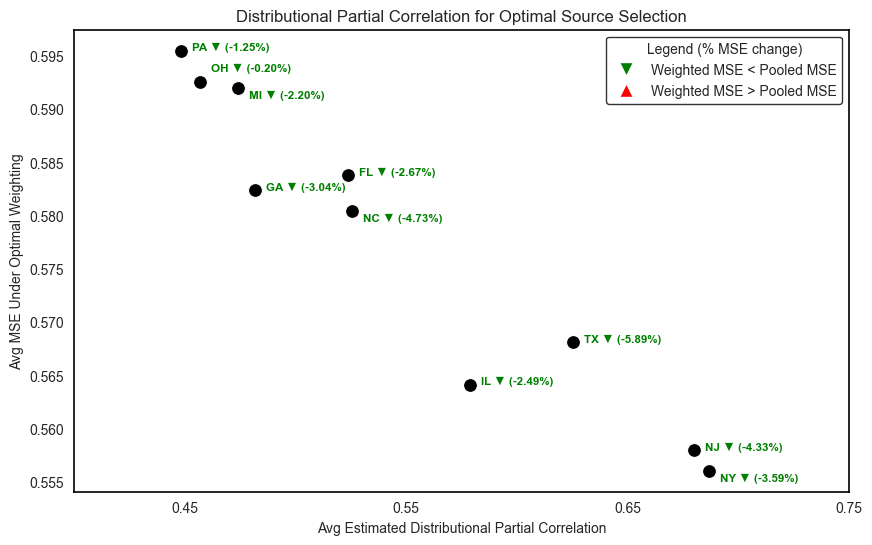

In [7]:

## Plot figure
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='duc', 
    y='weighted_mse_list', 
    data=results_df, 
    s=100, 
    color='black'
)

# Add labels for each point representing the state and triangles
for i in range(results_df.shape[0]):
    # Check whether weighted_mse < or > pooled_mse and assign the corresponding triangle
    if results_df['weighted_mse_list'][i] < results_df['pool_mse_list'][i]:
        marker = '▼'  # Green down arrow
        color = 'green'
    else:
        marker = '▲'  # Red up arrow
        color = 'red'
    
    # Calculate the percentage change
    weighted_mse = results_df['weighted_mse_list'][i]
    pooled_mse = results_df['pool_mse_list'][i]
    percentage_change = ((weighted_mse - pooled_mse) / abs(pooled_mse)) * 100 if pooled_mse != 0 else np.nan
    
    y_adjustment = 0
    if results_df['state_abbreviation'][i] == 'NY':
        y_adjustment = -0.001  # Move NY text lower
    elif results_df['state_abbreviation'][i] == 'NC':
        y_adjustment = -0.001  # Move NC text lower
    elif results_df['state_abbreviation'][i] == 'MI':
        y_adjustment = -0.001  # Move NC text lower
    elif results_df['state_abbreviation'][i] == 'OH':
        y_adjustment = +0.001  # Move NC text lower
    
    plt.text(results_df['duc'][i] + 0.005, results_df['weighted_mse_list'][i] + y_adjustment, 
             f"{results_df['state_abbreviation'][i]} {marker} ({percentage_change:.2f}%)", 
             horizontalalignment='left', size='small', color=color, weight='semibold', rotation=0)

# Set x-axis limits and ticks
plt.xlim(0.4, 0.75)
plt.xticks([0.45, 0.55, 0.65, 0.75])

# Create custom legend handles
legend_handles = [
    Line2D([0], [0], marker='v', color='w', markerfacecolor='green', markersize=10, label='Weighted MSE < Pooled MSE'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label='Weighted MSE > Pooled MSE')
]

# Style axis spines (add visible borders)
for spine in ['left', 'bottom', 'top', 'right']:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_color('black')  # Set border color
    plt.gca().spines[spine].set_linewidth(1.2)  # Set border thicknessa


# Add legend to the plot
plt.legend(handles=legend_handles, title='Legend (% MSE change)', edgecolor='black',facecolor='white')

# Set plot labels and title
plt.title('Distributional Partial Correlation for Optimal Source Selection')
plt.xlabel('Avg Estimated Distributional Partial Correlation')
plt.ylabel('Avg MSE Under Optimal Weighting')
plt.grid(False)
plt.gca().set_facecolor('white')
plt.show()
